<a href="https://colab.research.google.com/github/IOlivaresPalma/Multimedia-Trabajos/blob/main/Proyecto_2_OlivaresIvan_197615435.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: _______</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


In [1]:
!git clone 'https://github.com/Jorgecardenas1/EIE_401_MULTIMEDIA.git'

Cloning into 'EIE_401_MULTIMEDIA'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 347 (delta 1), reused 1 (delta 0), pack-reused 341
Receiving objects: 100% (347/347), 44.47 MiB | 21.39 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [ ]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [2]:
# Extraer carpeta de imagenes
from zipfile import ZipFile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

with ZipFile('/content/EIE_401_MULTIMEDIA/Proyectos/Proyecto 2/imagenes.zip', 'r') as zipObj:
  ZipFile.extractall(zipObj, 'imagenes')
  print('Done')

Done


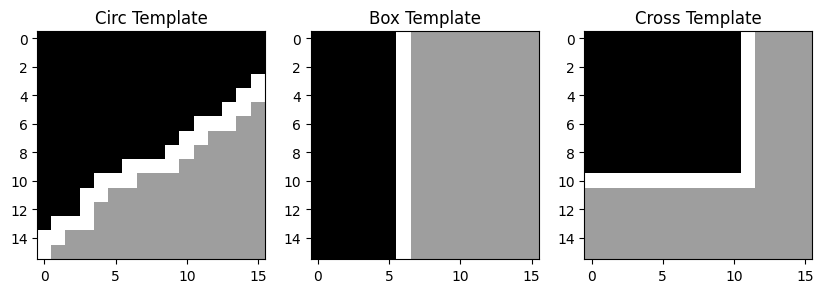

In [3]:
# Establecer mascaras box_templae - circ_templae - cross_templae
import cv2
import numpy as np
import matplotlib.pyplot as plt

circ_template = (cv2.imread('/content/EIE_401_MULTIMEDIA/Proyectos/Proyecto 2/circ_templae.png', cv2.IMREAD_GRAYSCALE))

box_template = (cv2.imread('/content/EIE_401_MULTIMEDIA/Proyectos/Proyecto 2/box_templae.png', cv2.IMREAD_GRAYSCALE))

cross_template = (cv2.imread('/content/EIE_401_MULTIMEDIA/Proyectos/Proyecto 2/cross_templae.png', cv2.IMREAD_GRAYSCALE))

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(circ_template, cmap='gray')
ax[0].set_title('Circ Template')

ax[1].imshow(box_template, cmap='gray')
ax[1].set_title('Box Template')

ax[2].imshow(cross_template, cmap='gray')
ax[2].set_title('Cross Template')

plt.show()

## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

In [ ]:
from scipy.fftpack import fft2, ifft2

# Función para realizar la transformada de Fourier
def apply_fft(image):
    return fft2(image)

Se utiliza de preferencia transformadas de Fourier, esto es porque la transformada Wavelet toma más tiempo que Fourier

## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


In [4]:
# Función para reducir y normalizar imágenes
def process_and_normalize_image(image_path, output_path, size=(512, 512)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(image, size)
    normalized_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(output_path, normalized_image)

In [5]:
import cv2
import numpy as np
import os
from sklearn.metrics import precision_score, confusion_matrix

# Definir las rutas de las carpetas
input_folder = '/content/imagenes/processed512/'
output_folder = '/content/imagenes_new/'
template_folder = 'ruta/a/carpeta/templates/'


# Crear la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Procesar todas las imágenes en la carpeta de entrada
for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    process_and_normalize_image(input_path, output_path,size=(256,256))

# normalizar templates

circ_template = cv2.normalize(circ_template, None, 0, 255, cv2.NORM_MINMAX)
box_template = cv2.normalize(box_template, None, 0, 255, cv2.NORM_MINMAX)
cross_template = cv2.normalize(cross_template, None, 0, 255, cv2.NORM_MINMAX)




## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación


Este proceso es similar a un windowing, donde la ventana es la imagen de referencia.
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [56]:
#Se establece un batch de imagenes
import random
import os

folder_img = '/content/imagenes_new/'
carpeta_list = os.listdir(folder_img)


batch_size = 50
img_escogidas = random.sample(carpeta_list,k=batch_size)

In [52]:
# Template Matching
from scipy.fft import fft2,ifft2
import cv2
import numpy as np
import matplotlib.pyplot as plt

def TemplateMatching(img,template):
  # tanto la imagen como el template deben estar normalizados
  # Se obtienen las transformadas de fourier para la imagen y el template

  img_fft = fft2(img)
  template_fft = fft2(template)
  img_fft_real = np.real(img_fft).astype(np.float32) # Cast to 32-bit float
  template_fft_real = np.real(template_fft).astype(np.float32) # Cast to 32-bit float

  #corr = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED) # Use real-valued arrays here
  corr = cv2.matchTemplate(img_fft_real,template_fft_real,cv2.TM_CCOEFF_NORMED) # Use real-valued arrays here
  corr = np.real(ifft2(corr))
  return corr

def obtener_MaxVal_MaxLoc(corr):
  min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(corr)
  return max_val, max_loc

def DetectImg(img,correlacion):
  pos_max = correlacion.index(max(correlacion))

  if pos_max == 0:
    #print(f"{img} clasificada como : Circulo")
    return 'circ'
  elif pos_max == 1:
    #print(f"{img} clasificada como : cuadrado")
    return 'box'
  else:
    #print(f"{img} clasificada como : cruz")
    return 'cross'


def Extraer_Etiqueta(name_img):
  name = name_img.split('_')
  return name[0]





# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.


In [59]:
# Prueba de las 50 imagenes
from timeit import default_timer as timer

start = timer()
Pos_Neg = {'Positivos': 0,'Negativos' : 0}

for imagen in img_escogidas:
  img = cv2.imread(os.path.join(output_folder, imagen), cv2.IMREAD_GRAYSCALE)
  corr_circle = TemplateMatching(img, circ_template)
  corr_box = TemplateMatching(img, box_template)
  corr_cross = TemplateMatching(img, cross_template)
  corr_values = [-1,-1,-1]
  corr_values[0] = obtener_MaxVal_MaxLoc(corr_circle)[0]
  corr_values[1] = obtener_MaxVal_MaxLoc(corr_box)[0]
  corr_values[2] = obtener_MaxVal_MaxLoc(corr_cross)[0]
  label = DetectImg(imagen,corr_values)
  etiqueta_real = Extraer_Etiqueta(imagen)
  #print(f"Etiqueta real: {etiqueta_real}")
  #print(f"Etiqueta inferida: {label}")

  if label == etiqueta_real:
    #print("La etiqueta es correcta")
    Pos_Neg['Positivos'] += 1
  else:
    #print("La etiqueta es incorrecta")
    Pos_Neg['Negativos'] += 1

Pos_Neg.values()
Precision = Pos_Neg['Positivos']/(Pos_Neg['Positivos']+Pos_Neg['Negativos'])
print(f"Precision: {Precision*100}%")

end = timer()
print(end - start)


Precision: 36.0%
1.0424857849993714


# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [ ]:
# Template Matching
from scipy.fft import fft2,ifft2
import cv2
import numpy as np
import matplotlib.pyplot as plt

def TemplateMatching(img,template):
  # tanto la imagen como el template deben estar normalizados
  # Se obtienen las transformadas de fourier para la imagen y el template

  img_fft = fft2(img)
  template_fft = fft2(template)
  img_fft_real = np.real(img_fft).astype(np.float32) # Cast to 32-bit float
  template_fft_real = np.real(template_fft).astype(np.float32) # Cast to 32-bit float

  #corr = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED) # Use real-valued arrays here
  corr = cv2.matchTemplate(img_fft_real,template_fft_real,cv2.TM_CCOEFF_NORMED) # Use real-valued arrays here
  corr = np.real(ifft2(corr))
  return corr

def obtener_MaxVal_MaxLoc(corr):
  min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(corr)
  return max_val, max_loc

def DetectImg(img,correlacion):
  pos_max = correlacion.index(max(correlacion))

  if pos_max == 0:
    #print(f"{img} clasificada como : Circulo")
    return 'circ'
  elif pos_max == 1:
    #print(f"{img} clasificada como : cuadrado")
    return 'box'
  else:
    #print(f"{img} clasificada como : cruz")
    return 'cross'


def Extraer_Etiqueta(name_img):
  name = name_img.split('_')
  return name[0]





In [61]:
from timeit import default_timer as timer
# Template Matching
from scipy.fft import fft2,ifft2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import os



start = timer()

carpeta_img = '/content/imagenes_new'
carpeta_list = os.listdir(carpeta_img)


Pos_Neg = {'Positivos': 0,'Negativos' : 0}

for imagen in carpeta_list:
  img = cv2.imread(os.path.join(carpeta_img, imagen), cv2.IMREAD_GRAYSCALE)
  corr_circle = TemplateMatching(img, circ_template)
  corr_box = TemplateMatching(img, box_template)
  corr_cross = TemplateMatching(img, cross_template)
  corr_values = [-1,-1,-1]
  corr_values[0] = obtener_MaxVal_MaxLoc(corr_circle)[0]
  corr_values[1] = obtener_MaxVal_MaxLoc(corr_box)[0]
  corr_values[2] = obtener_MaxVal_MaxLoc(corr_cross)[0]
  label = DetectImg(imagen,corr_values)
  etiqueta_real = Extraer_Etiqueta(imagen)
  #print(f"Etiqueta real: {etiqueta_real}")
  #print(f"Etiqueta inferida: {label}")

  if label == etiqueta_real:
    #print("La etiqueta es correcta")
    Pos_Neg['Positivos'] += 1
  else:
    #print("La etiqueta es incorrecta")
    Pos_Neg['Negativos'] += 1

Pos_Neg.values()
Precision = Pos_Neg['Positivos']/(Pos_Neg['Positivos']+Pos_Neg['Negativos'])
print(f"Precision: {Precision*100}%")

end = timer()
minutes = int((end-start)/60)
seconds = int((end-start)%60)
print(f"El código demoró: {minutes} minutos y {seconds} segundos")


Precision: 41.26186487995533%
322.83463573099834


In [64]:
minutes = int((end-start)/60)
seconds = int((end-start)%60)
print(f"El código demoró: {minutes} minutos y {seconds} segundos")

El código demoró: 5 minutos y 22 segundos
